In [34]:
from datasets import load_dataset

dataset = load_dataset("BoKelvin/SLAKE", split="train").select(range(2000))
test_dataset = load_dataset("BoKelvin/SLAKE", split="test").select(range(200))


In [35]:
dataset

Dataset({
    features: ['img_name', 'location', 'answer', 'modality', 'base_type', 'answer_type', 'question', 'qid', 'content_type', 'triple', 'img_id', 'q_lang'],
    num_rows: 2000
})

In [36]:
test_dataset

Dataset({
    features: ['img_name', 'location', 'answer', 'modality', 'base_type', 'answer_type', 'question', 'qid', 'content_type', 'triple', 'img_id', 'q_lang'],
    num_rows: 200
})

In [2]:
import torch
device = 'cuda'

print("Max cuda memory used:", torch.cuda.max_memory_allocated(device=device))

Max cuda memory used: 0


In [14]:
import os
import json
import pickle

dr = 'download/download/'
models = os.listdir(dr)
models.sort(reverse=True)
models

['blip2', 'blip-vqa-rad-model', 'blip-path-vqa-model']

In [53]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# sns.barplot(stats, x='rnn_module', y='loss', hue='mode', ax=ax[0])
# sns.barplot(stats, x='rnn_module', y='acc', hue='mode', ax=ax[1])
# sns.barplot(stats, x='rnn_module', y='time', ax=ax[2])


In [68]:
import seaborn as sns

stats = pd.DataFrame(columns=['model-dataset', 'loss', 'similarity', 'exact_match']);
stats.set_index(['model-dataset'], inplace=True)

md = {
    'blip2': 'blip2 + vqa-rad',
    'blip-vqa-rad-model': 'blip + vqa-rad',
    'blip-path-vqa-model': 'blip + path-vqa',
}

for model in models:
    dp = os.path.join(dr, model)
    # display(os.listdir(dp))
    print(model)
    with open(f"{dp}/answers.json", 'r') as rf:
        answers = json.load(rf)
    with open(f"{dp}/predicted_answers.json", 'r') as rf:
        predicted_answers = json.load(rf)
    with open(f"{dp}/tracking_information.pkl", 'rb') as rf:
        tracking_information = pickle.load(rf)
    m = compute_metrics(answers, predicted_answers)
    # print(tracking_information[9][1], len(tracking_information))
    stats.loc[md[model], 'loss'] = tracking_information[9][1]
    stats.loc[md[model], 'similarity'] = m['similarity']
    stats.loc[md[model], 'exact_match'] = m['exact_match']
    # display(m)
    # break
stats

blip2
blip-vqa-rad-model
blip-path-vqa-model


,loss,similarity,exact_match
model-dataset,,,
blip2 + vqa-rad,2.997172,0.02622,0.308204
blip + vqa-rad,0.347358,0.31827,0.297118
blip + path-vqa,0.62087,0.382423,0.288


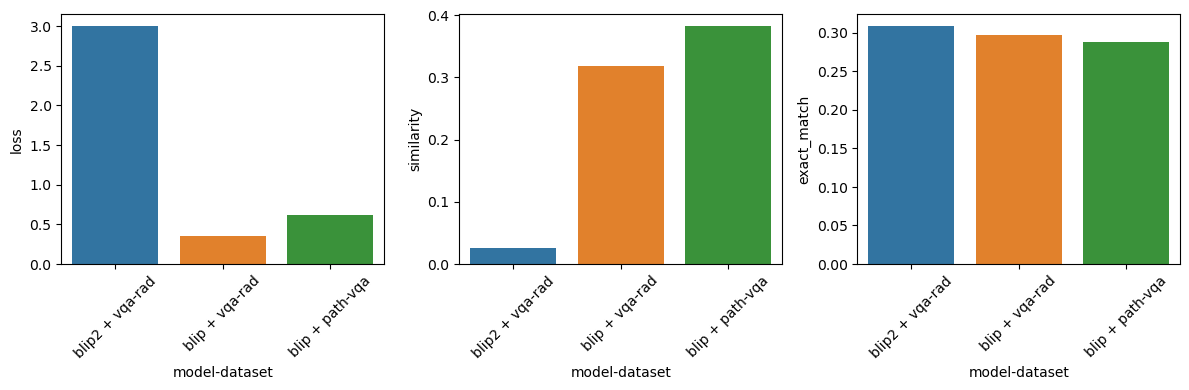

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.barplot(stats, x='model-dataset', y='loss', hue='model-dataset', ax=ax[0])
sns.barplot(stats, x='model-dataset', y='similarity', hue='model-dataset', ax=ax[1])
sns.barplot(stats, x='model-dataset', y='exact_match', hue='model-dataset', ax=ax[2])

for i, a in enumerate(ax):
    a.tick_params(axis='x', labelrotation=45)
fig.tight_layout()
fig.canvas.draw()
plt.savefig("blip2-blip-vqa.svg")

In [31]:
from collections import defaultdict
import sys, os, argparse, time, tqdm
from collections import defaultdict
import numpy as np
import pandas as pd
import torch
# import datasets, peft, evaluate
import datasets, evaluate
bleu_score_metric = evaluate.load('bleu')
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

def compute_metrics(true_answers, pred_answers):
    m = defaultdict(list)
    for i in range(len(true_answers)):
        true_answer = true_answers[i]
        pred_answer = pred_answers[i]
        if not pred_answer.strip():
            pred_answer = '_'

        similarity = SequenceMatcher(a=true_answer, b=pred_answer).ratio()
        exact_match = int(true_answer == pred_answer)
        if true_answer in ['yes','no']:
            exact_match = int(pred_answer.startswith(true_answer))
        m['exact_match'].append(exact_match)
        m['similarity'].append(similarity)
        
    m = {k: np.mean(v) for k, v in m.items()}
    
    try:
        bleu_result = bleu_score_metric.compute(
            predictions=pred_answers, references=true_answers
        )
    except ZeroDivisionError:
        print((true_answers, pred_answers))
        raise
    m['bleu_score'] = bleu_result['bleu']
    m['precision1'] = bleu_result['precisions'][0]
    m['precision2'] = bleu_result['precisions'][1]
    m['precision3'] = bleu_result['precisions'][2]
    m['precision4'] = bleu_result['precisions'][3]
    return m